In [19]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import itertools

In [2]:
rootfolder = '..'


In [20]:
def spark(matrix):
    m, n = matrix.shape
    for i in range(1, n+1):
        subsets = itertools.combinations(range(n), i)
        for subset in subsets:
            submatrix = matrix[:, subset]
            if np.linalg.matrix_rank(submatrix) < len(subset):
                return i
    return n+1

In [4]:
def psnrFun(m1, m2):
    diff = (m1 - m2).reshape(-1)
    mse = np.dot(np.transpose(diff), diff) / diff.shape[0]
    psnr = 10*np.log10(1/mse)
    return psnr

Useful function for plot the 2D DCT dictionary

In [5]:
def get_dictionary_img(D):
    M, N = D.shape
    p = int(round(np.sqrt(M)))
    nnn = int(np.ceil(np.sqrt(N)))
    bound = 2
    img = np.ones((nnn*p+bound*(nnn-1), nnn*p+bound*(nnn-1)))
    for i in range(N):
        m = np.mod(i, nnn)
        n = int((i-m)/nnn)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Define a function that implements the OMP

In [6]:
def OMP(s, D, L, tau):
  N = D.shape[1]
  x = np.zeros(N)
  r = s
  omega = []
  while np.count_nonzero(x) < L and np.linalg.norm(r) > tau:
      e = np.zeros(N)
      for j in range(N):
          e[j] = np.linalg.norm(r)**2 - ((r.T @ D[:, j])  / np.linalg.norm(D[:, j]))**2
      jStar = np.argmin(e)
      omega = np.append(omega, jStar).astype(int)
      x_omega =  np.linalg.inv(D[:, omega].T @ D[:, omega]) @ D[:, omega].T @ s
      x = np.zeros(N)
      x[omega] = x_omega 
      r = s - D @ x
  return x

Load the image and rescale it in $[0,1]$

In [7]:
img = imread(f'{rootfolder}/data/peppers256.png') / 255
# img = imread(f'{rootfolder}/data/barbara.png') / 255
# img = imread(f'{rootfolder}/data/Lena512.png') / 255

imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p ** 2


Corrupt the image with white gaussian noise

In [8]:
sigma_noise = 20/255
noisy_img = img + np.random.normal(size=imsz) * sigma_noise

Text(0.5, 1.0, 'Noisy image, PSNR = 22.08')

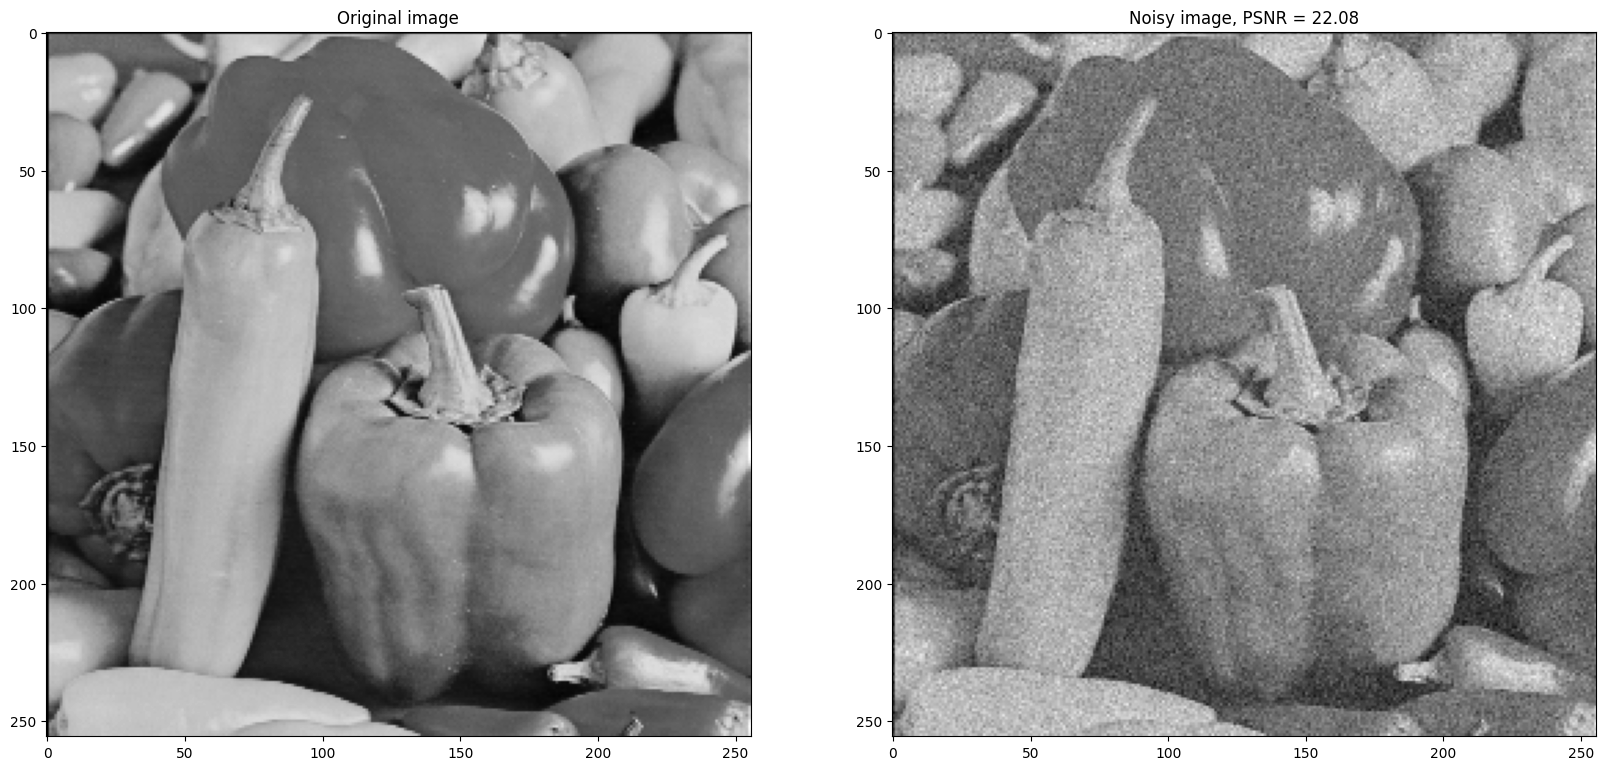

In [9]:
psnr_noisy = psnrFun(img, noisy_img)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')

Percentage of removed pixel

In [10]:
perc_of_removed_pixels = 0.25

Arbitrarily remove pixels setting them to zero

In [11]:
# create a vector with all the indexes of the image
idx = np.arange(imsz[0] * imsz[1])

# shuffle it and take the target percentage of indexes
idx = np.random.permutation(idx)
idx = idx[:int(np.round(perc_of_removed_pixels * imsz[0] * imsz[1]))]

# the mask is 0 for the chosen idx, 1 elsewhere
msk = np.ones(imsz)
msk.ravel()[idx] = 0

# apply the mask: set to 0 some elements in the noisy image
noisy_img = noisy_img * msk


Compute the psnr of the noisy input

In [12]:
psnr_noisy = psnrFun(img, noisy_img)


Text(0.5, 1.0, 'Mask')

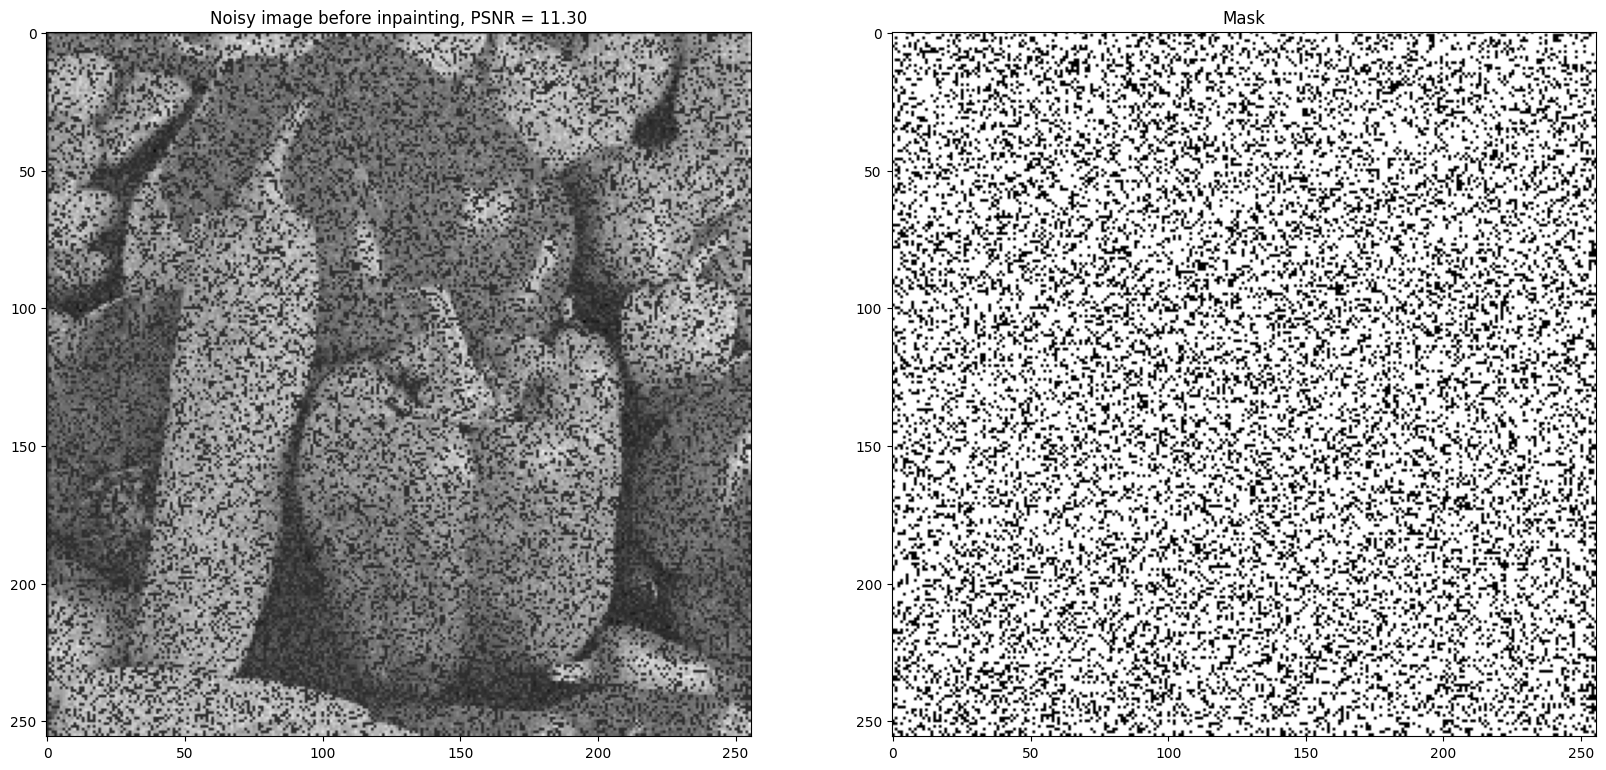

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(noisy_img, cmap='gray')
ax[0].set_title(f'Noisy image before inpainting, PSNR = {psnr_noisy:.2f}')

ax[1].imshow(msk, cmap='gray')
ax[1].set_title('Mask')


Load and display the dictionary learned from patches

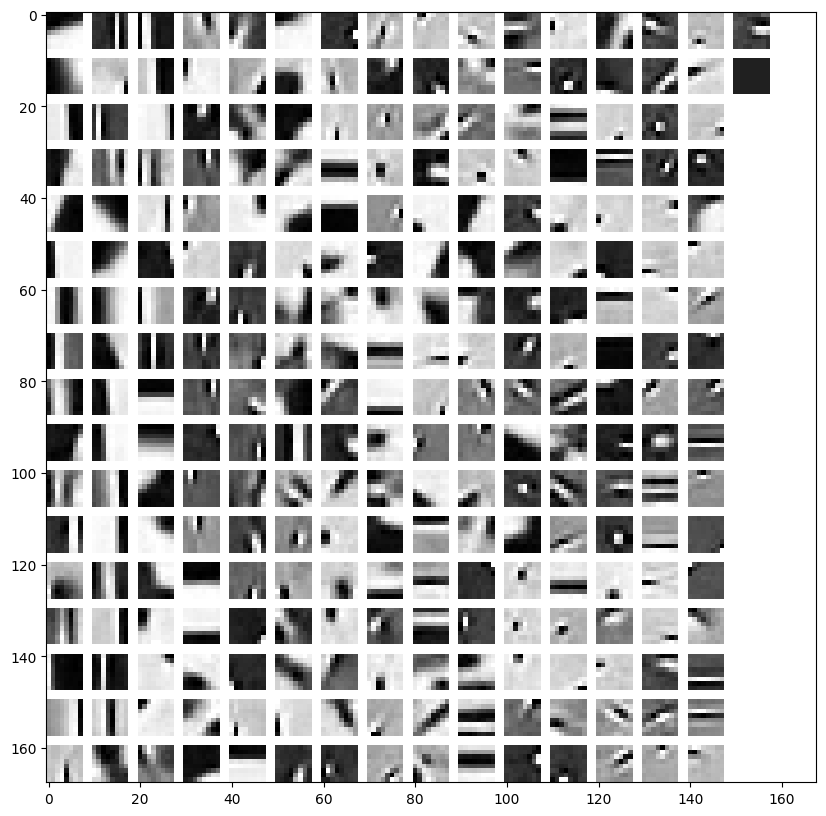

In [30]:
D = loadmat(f'{rootfolder}/data/dict_nat_img.mat')['D']

# add a constant atom to D, KSVD was trained over patches with zero mean - and normalize it
# UPDATE D
#D = np.concatenate((np.ones((M, 1)), D), axis=1)
D = np.block([D, np.ones((M, 1))])
D = D / np.linalg.norm(D, axis=0)

# display the dictionary
D_img = get_dictionary_img(D)

plt.figure(figsize=(10,10))
plt.imshow(D_img, cmap='gray')

In [27]:
#spark(np.block([np.zeros((5,1)) + 1, np.eye(5)]))
spark(np.block([np.eye(3), np.zeros((3,1))]))

1

In [16]:
matrix = np.block([np.zeros((5,5)) + 1, np.eye(5)])

Inpainting
----------


In [70]:
# SET stopping criteria of OMP
# orthogonal matching pursuit uses sparsity and errors as stopping criteria
L = M / 2

# initialize the estimated image
img_hat = np.zeros_like(img)

# initialize the weight matrix
weights = np.zeros_like(img)

# define the step (=p for non overlapping paches)
STEP = 1 # STEP = 1 might be very time consuming, start with larger STEP

Operate patchwise

In [71]:
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # Extract the patch with the top left corner at pixel (i, j)
        s = noisy_img[i:i + p, j:j + p].ravel(order='F')
        
        # Patch extracted from the mask
        m = msk[i:i + p, j:j + p].ravel(order='F')

        # Design the projection operator over the current patch
        proj = np.diag(m)

        # Tau should be proportional to the number of pixels remaining in the patch
        tau = 1.15 * p * sigma_noise * (M - np.count_nonzero(m)) / M

        # Sparse coding w.r.t. PD the inpainted dictionary using L and tau as stopping criteria
        PD = proj @ D

        x = OMP(s, PD, L, tau)

        # Reconstruction: synthesis w.r.t. D the dictionary yielding sparse representation
        s_hat = (D @ x).reshape((p, p), order='F')

        # Use uniform weights for aggregation
        w = 1

        # Put the denoised patch into the estimated image using uniform weights
        img_hat[i:i + p, j:j + p] += s_hat * w

        # Store the weight of the current patch in the weight matrix
        weights[i:i + p, j:j + p] += w
        



Normalize the estimated image with the computed weights

In [72]:
img_hat = img_hat / weights

Compute the psnr of the estimated image

Text(0.5, 1.0, 'Estimated Image,\nPSNR = 22.31')

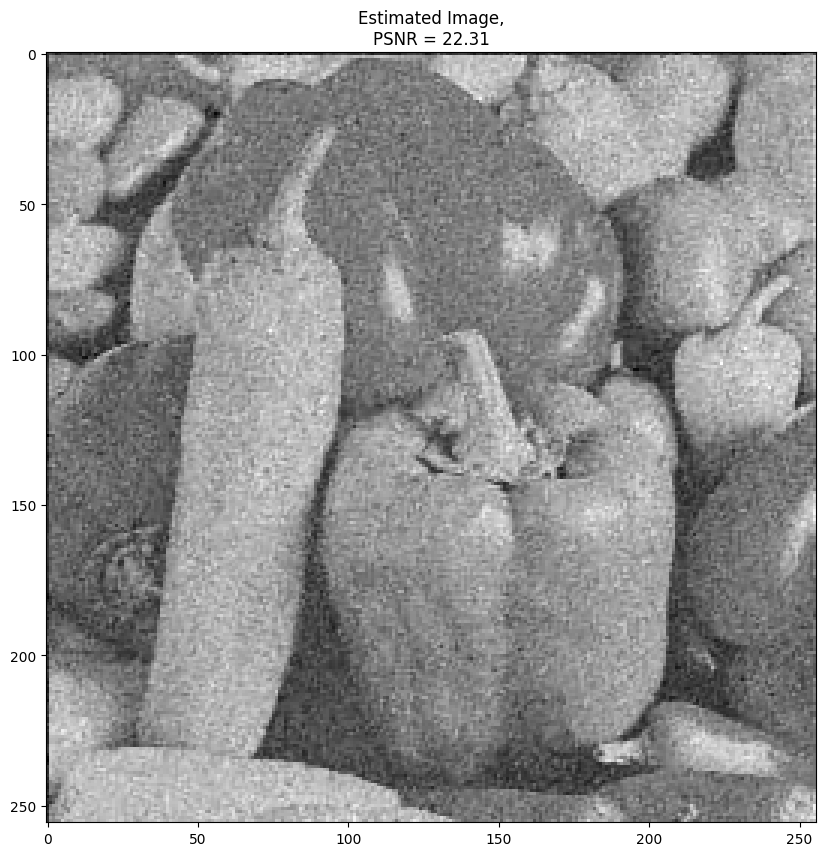

In [73]:
psnr_hat = psnrFun(img, img_hat)
plt.figure(figsize=(10,10))
plt.imshow(img_hat, cmap='gray')
plt.title(f'Estimated Image,\nPSNR = {psnr_hat:.2f}')
